# Image Tsne

### Import Variables

In [65]:
%matplotlib inline
import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image
from sklearn.manifold import TSNE
from tqdm import tqdm

### Parse all images in custom folder, saves their color and path into the data array

In [66]:
data = []
folder = 'bilder/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])


100%|██████████| 29/29 [00:00<00:00, 71.49it/s]


In [67]:
data

[[array([255, 255, 255, ..., 189, 182, 177], dtype=uint8),
  'bilder/original_left10_.png'],
 [array([255, 255, 255, ..., 189, 182, 176], dtype=uint8),
  'bilder/original_left11_.png'],
 [array([255, 255, 255, ..., 190, 183, 177], dtype=uint8),
  'bilder/original_left12_.png'],
 [array([ 93,  97, 197, ..., 174,  98,  95], dtype=uint8),
  'bilder/original_left13_.png'],
 [array([ 87, 111, 162, ..., 146,  86,  85], dtype=uint8),
  'bilder/original_left14_.png'],
 [array([ 91, 156, 161, ..., 196, 108, 108], dtype=uint8),
  'bilder/original_left15_.png'],
 [array([ 90, 163, 175, ..., 187, 100, 102], dtype=uint8),
  'bilder/original_left16_.png'],
 [array([255, 255, 255, ..., 192, 186, 181], dtype=uint8),
  'bilder/original_left1_.png'],
 [array([255, 255, 255, ..., 192, 186, 180], dtype=uint8),
  'bilder/original_left2_.png'],
 [array([255, 255, 255, ..., 187, 181, 178], dtype=uint8),
  'bilder/original_left3_.png'],
 [array([255, 255, 255, ..., 198, 191, 186], dtype=uint8),
  'bilder/orig

### Training part

imagesinstantiate a PCA object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [68]:
features, images  = zip(*data)

In [69]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=20)
pca.fit(features)
pca_features = pca.transform(features)

In [70]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [80]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=10, perplexity=10, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 29 samples in 0.000s...
[t-SNE] Computed neighbors for 29 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 29 / 29
[t-SNE] Mean sigma: 773.160812
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 43.1359444, gradient norm = 0.8892556 (50 iterations in 0.017s)
[t-SNE] Iteration 100: error = 37.8235512, gradient norm = 0.9766940 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 36.8342476, gradient norm = 1.2174028 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 39.9365654, gradient norm = 0.8329495 (50 iterations in 0.022s)
[t-SNE] Iteration 250: error = 38.8953018, gradient norm = 0.8633156 (50 iterations in 0.019s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.895302
[t-SNE] Iteration 300: error = 0.0321744, gradient norm = 0.0028101 (50 iterations in 0.013s)
[t-SNE] Iteration 350: error = 0.0263182, gradient norm = 0.0036972 (50

In [72]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

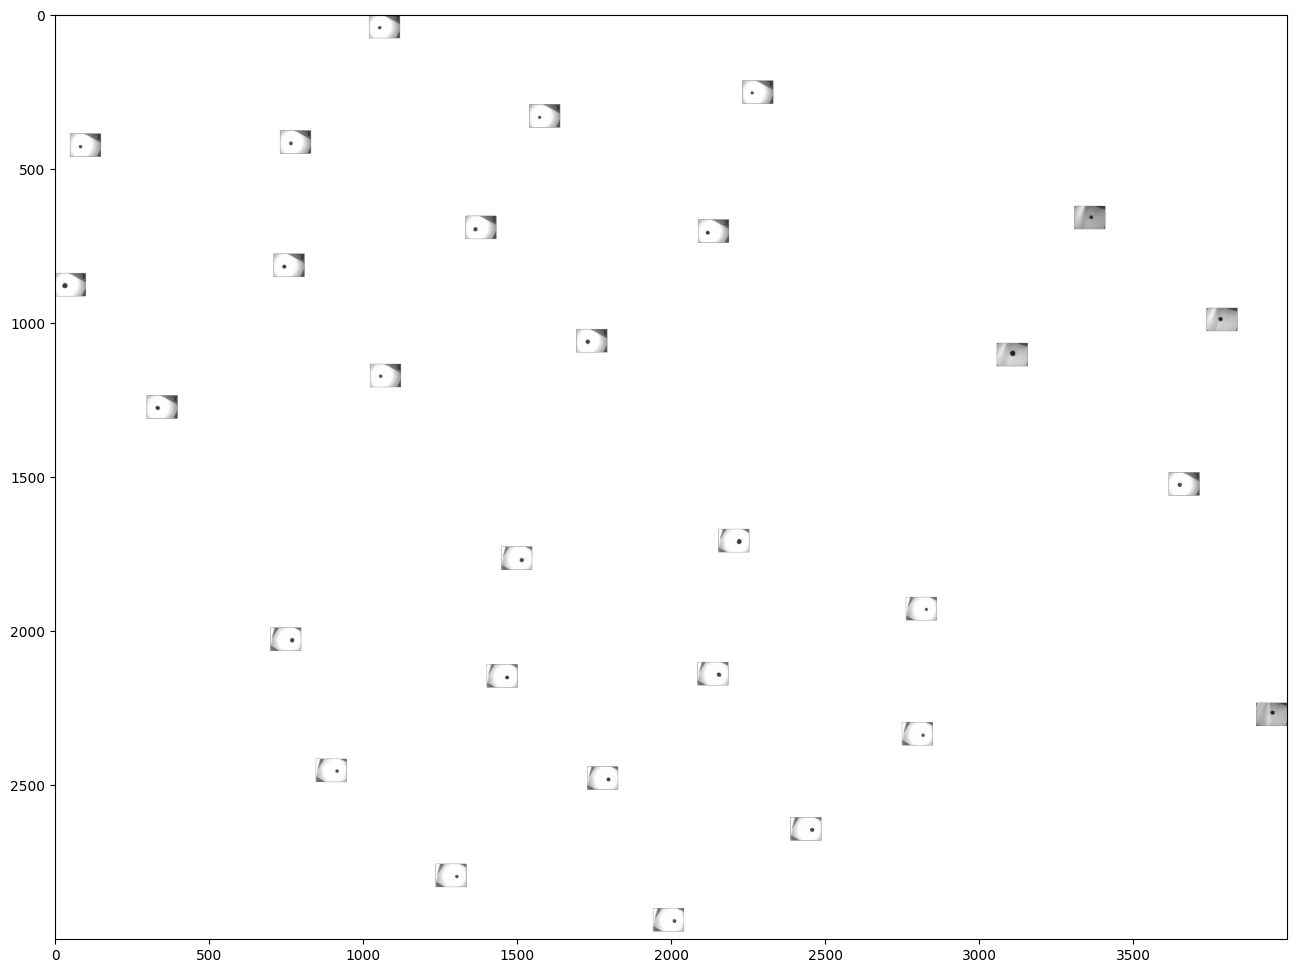

In [73]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)))
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)




In [74]:
import PIL
print(PIL.__version__)


10.1.0


### Save a json and a png of the cluster

In [75]:
import os
import json

full_image.save("test_tSNE.png")

tsne_path = "test_tSNE.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


saved t-SNE result to test_tSNE.json


### Paste into grid

In [76]:
def arrange_in_grid(points, nx, ny):
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    
    x_grid = np.linspace(x_min, x_max, nx)
    y_grid = np.linspace(y_min, y_max, ny)
    
    grid_points = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1, 2)
    
    return grid_points[:len(points)]

# Arrange points in a grid
grid_assignment = arrange_in_grid(tsne, nx, ny)

In [77]:
tile_width = 50
tile_height = 50

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

TypeError: cannot unpack non-iterable numpy.float64 object

### Save the image

In [ ]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('grid-tSNE.jpg', 'JPEG', quality=100)